## Statistical Methods for the Physical Sciences (5214SMFA3Y)
## Individual mini-Project -- Model fitting and hypothesis testing: the search for WIMPs
### Timo Halbesma, 6126561, 2016/01/08

In [77]:
# Enable showing plots inside iPython notebook
%matplotlib inline

In [78]:
import scipy
from scipy import stats
import numpy
import matplotlib
from matplotlib import pyplot
from matplotlib.ticker import MaxNLocator
import pandas

matplotlib.rcParams.update({'font.size': 22})

### Introduction
Current data from the Fermi gamma-ray observatory is providing hints of the existence of anomalous extended GeV gamma-ray emission at the centre of our galaxy. This GeV continuum emission is causing excitement in the astroparticle-physics community, because it may be associated with the decay of the hitherto-undetected weakly interacting massive particles (WIMPs), which are thought to make up dark matter.

This mini-project is based on analysing simulated spectral data from a hypothetical future gamma-ray observatory, whose main objective is to search for and study the extended dark matter decay signature in the centres of nearby galaxies. The data consists of a list of energies of photons detected in an observation of a nearby galaxy. Your task is to convert this data into a gamma-ray spectrum (this is just a histogram of photon numbers versus energy in discrete energy bins), carry out some simple tests and determine the shape of the continuum (with errors on the model parameters) as well as search for and characterise spectral emission lines.


### Objectives
_Important note_: throughout all of the following you should assume that in addition to any astrophysical source photons with spectra described below, there is an additional instrumental background photon continuum which contributes a constant number of photons per GeV. For the dataset you are given, $C = 1.5$ photons/GeV.

### Question 1
- The simple alternative to dark matter decay is that the continuum is produced by the combined unresolved emission from a large number of gamma-ray pulsars in the centre of the target galaxy. Assume that the spectrum of gamma-ray pulsars is a simple power- law following the relation: $$ dN = N_0 \left( \frac{E}{E_0} \right)^{-\Gamma} dE $$ where in our formalism, $dN$ is the number of photons expected in the infinitesimal energy range $dE$, and $N_0$ is the normalisation of the spectrum (in photons/GeV) at a fixed photon energy $E_0$. $\Gamma$ is the power-law index and is also known as the 'photon index'. Assuming that $\Gamma = 2$, use a _non-parametric significance test_ to compare the shape of this pulsar spectrum with that of your data (note that you don't need to know $N_0$!).

### Answer 1

We know of three different non-parametric significance tests: Spearman's $\rho$, the Kolmogorov-Smirnov and looking at the mean of the data. We will look at the KS-test first, where we check the theoretical cdf against the cdf obtained from the data.

In the words of Tom Riley:
>I would think about the **theoretical** cumulative distribution model as:
> $$ p(E) = \left( \int\limits_{\forall E} \frac{dN}{dE} dE \right)^{-1} \times \frac{dN}{dE} $$ $$ P (E < E') = \int\limits_{0}^{E'} p(E) dE $$
> Then compare the empirical cumulative distribution to the theoretical distribution by computing the above integral for E^{\prime} being the energies in your raw data. Then calculate the KS test statistic based on the set of differences for the set {E^{\prime}}. Note that the lower limit is zero if there is no **known** selection bias against photons with energies less than the lowest energy in the sample. The limits on the integral should in general be dependent on the sensitivity domain of the instrument.

> This is what Phil means in the PDF document by comparing to the **shape** of the spectrum. Notice that p(E) is not dependent on N_0 nor E_0. When you have a constant finite photon background, then
> $$ P(E < E') = \frac{E'}{E_{\rm max}} + \int\limits_{0}^{E'} p(E) dE $$
> Here E_max is the same as the upper limit on the integral for normalisation of the pulsar spectrum, and should probably be set to the maximum **observed** photon energy.

Here
\begin{align}
p(E) &= \left( \int\limits_{\forall E} \frac{dN}{dE} dE \right)^{-1} \times \frac{dN}{dE} = \left( \int\limits_{\forall E} N_0 \left( \frac{E}{E_0} \right)^{-\Gamma} dE \right)^{-1} \times N_0 \left( \frac{E}{E_0} \right)^{-\Gamma} \\
&= \left[ \left(\frac{E}{1-\Gamma}\right) N_0 \left(\frac{E}{E_0}\right)^{-\Gamma} \right]^{-1} \times N_0 \left( \frac{E}{E_0} \right)^{-\Gamma} = \frac{1-\Gamma}{E} \\
\\
P(E < E') &= \frac{E'}{E_{\rm max}} + \int\limits_{0}^{E'} p(E) dE = \frac{E'}{E_{\rm max}} + \int\limits_{0}^{E'} \frac{1-\Gamma}{E} dE \\
&= \frac{E'}{E_{\rm max}} + \left[ - \log(E) \right]_{0}^{E'}
\end{align}

In [79]:
def parse_and_clean_dataset(filename="Halbesma_energies.txt"):
    ''' read data from file
        clean is not needed; file only contains one column with .2f '''
    energies = numpy.genfromtxt(filename, skiprows=0)
    
    return energies


def non_parametric_significance_test(energies):
    ''' Assume spectum of gamma-ray pulsars is simple power low (not dark matter decay)
        dN = N_0 (E/E_0)**(-Gamma) dE
            
    Assume Gamma = 2, then perform non-parametric significance test to compare shape
        of pulsar spectrum with that of the data
    '''
    
    energies = numpy.sort(energies)
    min_energy = numpy.min(energies)
    max_energy = numpy.max(energies)
 
    p = energies/max_energy + (-1.*numpy.log10(energies) + numpy.log10(min_energy))
    
    # pyplot.plot(p)
    # pyplot.show()    
    
    # Perform Kolmogorov-Smirnov test
    
    cdf = energies/numpy.max(energies) - numpy.log10(energies)
    
    model = numpy.random.uniform(0, numpy.max(energies), len(energies))**-2
        
    (D_value, p_value) = scipy.stats.ks_2samp(energies, model)
    # (D_value, p_value) = scipy.stats.kstest(energies, 'powerlaw', (2.0, 0.0, 1.0))
    
    print "The (Scipy built-in) K-S test gives us a D-value of {0:.5f}".format(D_value),
    print "corresponding to a p-value of {0:.5f}.".format(p_value)
    
    certain = 1.0 - p_value

    print "This means that with {0:.5f} certainty we can say".format(certain),
    print "that the two samples are drawn from a different distribution."
    print
    
    # Calculate Spearman's rho correlation co-efficient
    n = len(energies)
    rho, pval = scipy.stats.spearmanr(energies, model)
    t = rho * numpy.sqrt((n - 2) / (1 - rho**2))
    print "Spearman's Rho = {0}, p-value = {1}\nt = {2}".format(rho, pval, t)
    

if __name__ == '__main__':
    energies = parse_and_clean_dataset()
    non_parametric_significance_test(energies)

The (Scipy built-in) K-S test gives us a D-value of 0.99844 corresponding to a p-value of 0.00000.
This means that with 1.00000 certainty we can say that the two samples are drawn from a different distribution.

Spearman's Rho = -0.0058751393699, p-value = 0.399645140322
t = -0.842272680685


** Performing non-parametric significance tests **

There are two non-parametric significance tests we would like to perform, the K-S test and Spearman's $\rho$.

The Kolmogorov-Smirnov is implemented in Scipy. From the documentation:
> This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

> If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

Here we have a very low $p$-value, which would mean that we have to reject $H_0$ that the samples are drawn from the same distribution, so this would imply that the assumed model is very poor to describe the data.

The next non-parametric significance test we can perform is Spearman's Rho test. From the documentation:
>Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship

> The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, has same dimension as rho.

Here we see a high low $\rho$ in the order of zero. This means that both samples are uncorrelated. The corresponding $p$-value given is the $p$-value for the null hypothesis $H_0$ that if the two sets of data are uncorrelated the obtained $\rho$ would have the same dimensions as found.

The calculated $P(E < E')$ does not seem to make sense

### Question 2
- Fit the observed spectrum with continuum models and find the best-fitting model. You should compare the following three possibilities:
    - A simple power-law.
    - A broken power-law:
    $$ dN = N_0 \left( \frac{E}{E_0} \right)^{-\Gamma_1} dE \quad \rm{ for } E \leq E_{\rm bk} $$ $$ dN = N_0 \left( \frac{E_{\rm bk}}{E_0} \right)^{-\Gamma_1} \left( \frac{E}{E_{\rm bk}} \right)^{-\Gamma_2} dE \quad \rm{ for } E > E_{\rm bk} $$ where $E_{\rm bk}$ is the break energy and $\Gamma_1$ and $\Gamma_2$ denote respectively the photon indices below and above the break energy.
    - An exponentially cut-off power-law:
    $$ dN = N_0 \left( \frac{E}{E_0}\right)^{- \Gamma} \exp\left(-E/E_{\rm cut}\right) dE $$ where $E_{\rm cut}$ is the cut-off energy.

### Answer 2

In [80]:
def inspect_data(energies):
    ''' Inspect the data to see the effect of the chosen binsize.
        NB: not correct for background, bins with <20 counts are not cut '''
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pyplot.subplots(3, 2, figsize=(12, 18))
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    
    # Use a different set of 'best'-practice number of bins (equally spaced binsizes)
    # htt/s://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width
    N = len(energies)
    # Freedman–Diaconis rule
    h = (2*numpy.subtract(*numpy.percentile(energies, [75, 25]))*N**(-1./3))
    FD = numpy.ceil((numpy.max(energies) - numpy.min(energies)) / h)
    sturges = numpy.ceil(numpy.log2(N)+1)  # assumes normal distribution
    rice = numpy.ceil(2*N**(1./3))
    
    bins = [sturges, rice, FD, int(numpy.sqrt(N)), 500, 700]
    labels = [r'$\log_2 (N)+1$', r'$2*N^{1/3}$', r'FD', r'$\sqrt{N}$', "fixed", "fixed"]
    for i, (ax, nr_of_bins) in enumerate(zip(axes, bins)):
        counts, edges = numpy.histogram(energies,
            range=[numpy.min(energies), numpy.max(energies)],
            bins=nr_of_bins, density=False)
        
        ax.plot(edges[1:], counts, lw=3, ls="steps-mid", label=labels[i])
        ax.axhline(20, c="r", lw=2, ls="dashed")
    
        ax.set_title("nr_of_bins = {0}".format(nr_of_bins))
        ax.set_ylabel("Counts")
        ax.set_xlabel("E (GeV)")
        ax.set_yscale("log")
        ax.legend()
    
    fig.tight_layout()
    pyplot.show()

** Binning the data **

The first step is to visually inspect the data, and try to determine an optimal number of bins. We set a hard limit on the minimum number of counts in each bin. If the number of counts is higher than twenty, then we can assume the error on the counts in the bins is normally distributed and we can use the $\chi^2$ statistic later on for our fitting routines. The optimal number of bins is not trivial, but some formulae are available which indicate the optimal binsize, or the optimal number of bins as a function of the sample size. We use several to inspect the data.

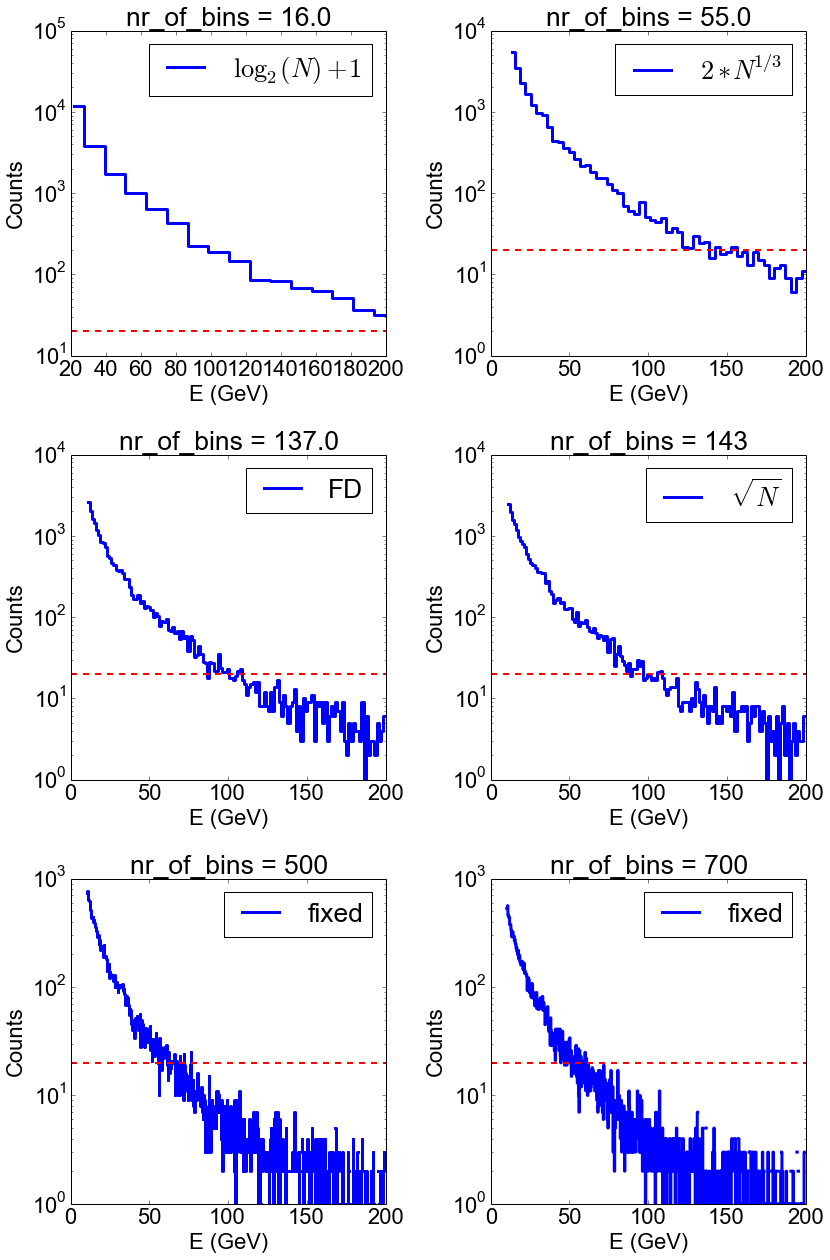

In [81]:
if __name__ == '__main__':
    energies = parse_and_clean_dataset()
    inspect_data(energies)

In the above plot the red dashed horizontal line indicates the twenty count cut-off. We observe that underbinning results in missing features in the low-energy part of the spectrum, whereas over-binning leads to cutting the tail of the distribution. This will be a problem later on, because we will fit three different models. Should we cut the data above the break- or cut-off energy we will effectively only fit one model (the simple power law). We really want to have the features in the low-energy part of the spectrum in addition to not-igonoring the tail of the distribution.

The solution to this problem could be to use unequally spaced bins, which according to dr. Uttley is perfectly fine ("There is no reason you should not be able to use unevenly spaced bins"). This way we will get a roughly equal count rate in each bin.

In [82]:
def bin_data_adaptive(energies, adaptive=True):
    ''' bin data in unevenly spaced bins --> count rate is roughly equal over all x '''

    # Fit routines should like smaller numbers better *_*
    energies = energies / (numpy.mean(energies))

    if adaptive:
        # Bin data using 'adaptive' bin sizes
        counts, edges = numpy.histogram(energies,
            range=[numpy.min(energies), numpy.max(energies)],
            bins=numpy.percentile(energies, range(0, 101, 2)), density=False)
    else:
        N = len(energies)
        # Freedman–Diaconis rule
        h = (2*numpy.subtract(*numpy.percentile(energies, [75, 25]))*N**(-1./3))
        FD = numpy.ceil((numpy.max(energies) - numpy.min(energies)) / h)
        counts, edges = numpy.histogram(energies,
            range=[numpy.min(energies), numpy.max(energies)],
            bins=FD, density=False)
    
    # Calculate the binsizes (which is different for each bin!)
    binsizes = numpy.zeros(len(counts), dtype=numpy.float64)
    for i in range(0, len(edges)-1):
        binsizes[i] = edges[i+1] - edges[i]  # in GeV

    # Cut the bins with less than 20 counts --> Poisson
    # NB using adaptive method there should not be bins with less than 20 counts (e.g. in the tail)
    counts = counts[counts > 20]
    # Reduce length of edges and binsize too
    edges = edges[0:len(counts) + 1]  # +1 because len(edges) = len(counts) +1
    binsizes = binsizes[0:len(counts)]

        
    # Calculate intrinsic error of bin. 
    # NB this must be done before correcting for background!
    # We assume --> err = sqrt(N) is normally distributed (since counts > 20)
    sample_size = len(energies)
    err = numpy.sqrt(counts) / (sample_size * binsizes)
    
    # Correct for background counts: C = 1.5 photons/GeV
    counts = counts - (1.5 * binsizes)
  
    # Calculate density
    dens = counts / (sample_size * binsizes)

    return dens, edges, err

    
def plot_histogram(energies, adaptive=False):
    ''' Display a plot of the pyplot binned data, and self-binned data '''
    dens, edges, err = bin_data_adaptive(energies, adaptive=adaptive)
    
    f, (ax1, ax2) = pyplot.subplots(2, 1, figsize=(12, 18))
    # NB not corrected for background photons, bins not cut when counts < 20!
    # So this can be used as a sanity check because it is only the binned data!
    ax1.hist(energies/numpy.mean(energies), bins=143, facecolor='b',
             label="pyplot binned", alpha=0.5, normed=True)

    ax1.plot(edges[1:], dens, lw=2, c="r",
             ls="steps-mid", label="adaptive binned" if adaptive else "numpy binned")
    ax1.set_ylabel("p(x)")
    ax1.set_xlabel(r'$\frac{E}{<E>}$')
    ax1.set_title("Histogram of raw data plus {0} binned data".format("adaptive" if adaptive else "numpy"))
    ax1.legend(loc=1)
   
    # Riley-style plot of the binned data, but log-log plot
    ax2.plot(edges[1:], dens, lw=3, c="black",
             ls="steps-mid", label="adaptive binned" if adaptive else "numpy binned")
    ax2.set_ylabel("p(x)")
    ax2.set_xlabel(r'$\frac{E}{<E>}$')
    # ax2.set_title("Log-log plot of adaptive binned data")
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.legend(loc=1)

    pyplot.show()

Since Riley was kind enough to provide solutions for the previous assignment, and this assignment is similar to the last question of said assignment: why not use Riley's code as a starting point? Or in some cases simply steal Riley's code :-)... I mean, it's the teacher's code so it must be correct and this must be the way to go, right? Also, it's there, this is not a programming course but a statistics course, and nobody likes to invent the wheel all over again. Credits for quite a lot of code used troughout this assignment are mostly due to Riley, but significant changes have been made.


In the words of Riley: 
> Let's first load in the data, normalise the ~~count rate~~ **energy** values by the mean ~~count rate~~ **energy** (anticipating that it will be easier to optimize our fit with smaller x values), bin the ~~count rate~~ **energy** values into evenly-sized bins, and discard the bins in the tails of the distribution if they have < 20 counts. We can then calculate the error on the probability density of each bin based on the assumption that we can approximate the binning process as following a Poisson distribution (it actually follows a binomial distribution, since we are dealing with the probability that a given x-value is binned into the bin of interest). Then we can set error = $\sqrt{n}$, where $n$ is the number of values in the bin. This makes sense if you just notice that the variance of a Poisson distribution is the expected ~~count rate~~ **energy**.

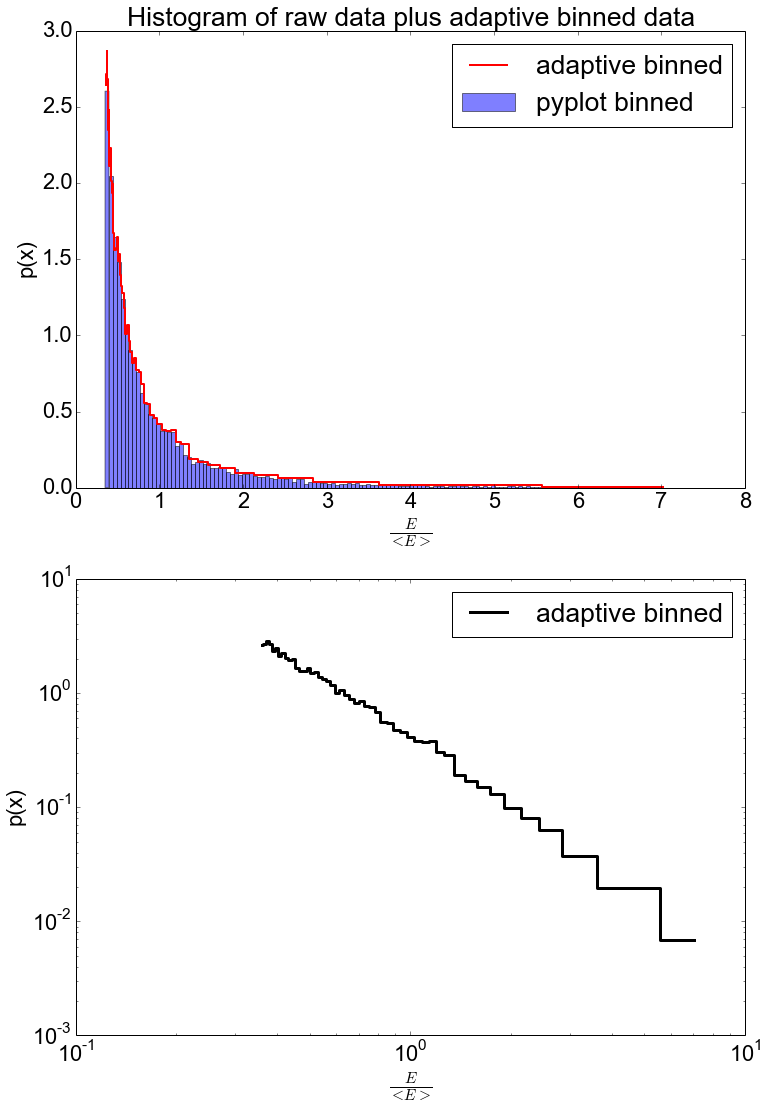

In [83]:
if __name__ == '__main__':
    plot_histogram(energies, adaptive=True)

Mind you, the blue histogram is generated from the raw data. Here matplotlib bins the data in a fixed number of bins (not adaptive), it is not corrected for background photons and bins with counts < 20 are not ignored (which will be found in the tail of the distribution). So this can be used as a sanity check because it is only the binned data, nothing else happend. Since the background is relatively low (only 1.5 photon/GeV) one does not visually observe that difference. The second plot is generated using Riley's code and changing the axis to log-log. If we expect a power law, then the binned data should look like a straight line in a log-log plot where the slope is the power law index.

Now also look at the non-adaptive histogram.

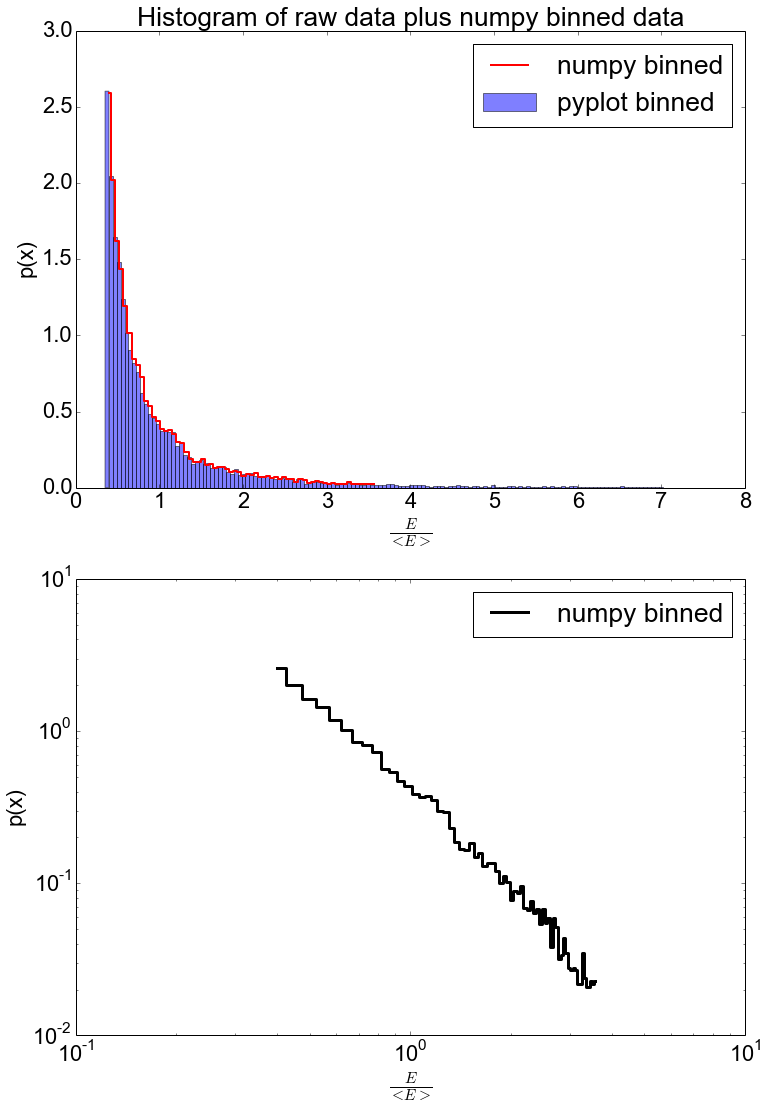

In [84]:
if __name__ == '__main__':
    plot_histogram(energies, adaptive=False)

The function is also for non-adpative binning, using the Freedman-Diaconis scheme for the number of bins. We can see clearly from the histogram that the data is cut from the tail (see the red line, it stops between 3 and 4 $E/<E>$) since the count rate falls below 20 counts.

Next, we define our three models, our statistical model, write a fitting routine and output the MLEs and chisq/dof. The method used is copy-pasted from Riley's code but adjusted for the new models.

[MLEs], chisq/dof: [ 0.60459039  0.77762937  2.12076435] 7.25916340447
The p-value for the simple distribution is: 0.00000
[MLEs], chisq/dof: [ 0.83174927  0.67837549  1.94912885  2.72820151  1.92582045] 2.22975341851
The p-value for the broken distribution is: 0.00000
[MLEs], chisq/dof: [ 0.10875274  1.58259172  0.73248181  1.92148886] 1.87935138488
The p-value for the expcut distribution is: 0.00028


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:61: RuntimeWarning: floating point number truncated to an integer


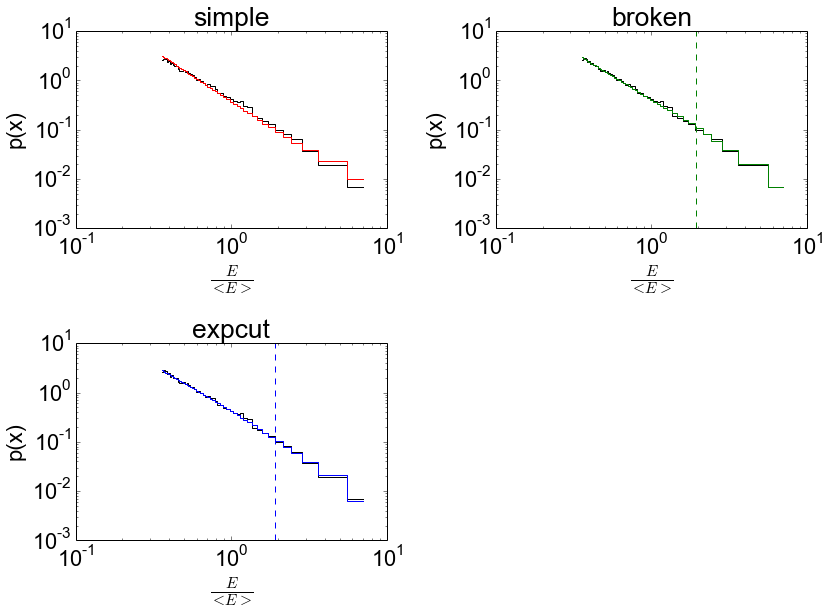

In [85]:
# Define our three models
def simple_power_law(parm, edges):
    N_0 = parm[0]
    E_0 = parm[1]
    Gamma = parm[2]
    
    # We have given the edges which allow us to do the integration over the bin
    E_left = edges[:-1]
    E_right = edges[1:]
    binsize = E_right - E_left
    
    # Formula integrated over bin
    counts = (N_0 * E_right/(1. - Gamma) * (E_right/E_0)**(-1. * Gamma)) \
        - (N_0 * E_left/(1. - Gamma) * (E_left/E_0)**(-1. * Gamma))
    
    # Now transform to density instead of counts
    dens = counts / binsize
    return dens


def broken_power_law(parm, edges):
    N_0 = parm[0]
    E_0 = parm[1]
    Gamma_1 = parm[2]
    Gamma_2 = parm[3]
    E_bk = parm[4]
    
    # We have given the edges which allow us to do the integration over the bin
    E_left = edges[:-1]
    E_right = edges[1:]
    binsize = E_right - E_left
    E_center = (E_left + E_right)/2.
    
    E_below_left = E_left[E_center <= E_bk]
    E_below_right = E_right[E_center <= E_bk]
    E_above_left = E_left[E_center > E_bk]
    E_above_right = E_right[E_center > E_bk]
    
    # Formula integrated over bin
    counts_below = \
        (N_0 * E_below_right/(1. - Gamma_1)\
        * (E_below_right/E_0)**(-1. * Gamma_1)) \
        - (N_0 * E_below_left/(1. - Gamma_1) \
        * (E_below_left/E_0)**(-1. * Gamma_1))
        
    counts_above = \
        (N_0 * (E_bk/E_0)**(-1. * Gamma_1) * E_above_right/(1. - Gamma_2)\
        * (E_above_right/E_bk)**(-1. * Gamma_2)) \
        - (N_0 * (E_bk/E_0)**(-1. * Gamma_1) * E_above_left/(1. - Gamma_2)\
        * (E_above_left/E_bk)**(-1. * Gamma_2))
        
    counts = numpy.concatenate([counts_below, counts_above])

    # Now transform to density instead of counts
    dens = counts / binsize
    return dens


def exponentially_cut_off_power_law(parm, edges):
    N_0 = parm[0]
    E_0 = parm[1]
    Gamma = parm[2]
    E_cut = parm[3]

    # We have given the edges which allow us to do the integration over the bin
    E_left = edges[:-1]
    E_right = edges[1:]
    binsize = E_right - E_left
    
    counts = (-1. * N_0 * (E_right/E_0)**(-1. * Gamma)\
        * E_right * scipy.special.expn(Gamma, E_right/E_cut)) \
        - (-1. * N_0 * (E_left/E_0)**(-1. * Gamma) \
        * E_right * scipy.special.expn(Gamma, E_left/E_cut))
    
    # Now transform to density instead of counts
    dens = counts / binsize
    return dens


# Define the statistical model, in this case we shall use a chi-squared distribution, assuming normality in the errors
def stat(parm, edges, y, dy, dist):
    if "gauss" in dist:
        dist = dist.split("_")[0]
        E_cent = parm[-1]
        N_line = parm[-2]
    if dist == "simple":
        ymod = simple_power_law(parm, edges)
    elif dist == "broken":
        ymod = broken_power_law(parm, edges)
    elif dist == "expcut":
        ymod = exponentially_cut_off_power_law(parm, edges)
    else:
        print "This function is not defined....choose another"
        return None 
    if "gauss" in dist:
        ymod += gauss(parm, edges)
    X = sum((y - ymod)**2 / dy**2)
    return(X)


def fit_observed_spectrum_with_continuum_models(energies, find_emissionline=False, adaptive=True):
    # change nr_of_bins to an integer value to change the number of bins.
    dens, edges, err = bin_data_adaptive(energies, adaptive=adaptive)
        
    # define an array of different dist names
    dists = ["simple", "broken", "expcut"]
    results = {}

    for i in xrange(len(dists)):
        # bounds=None
        if dists[i] == "simple":
            # [N_0, E_0, Gamma]
            parm = [1.1, 1.5, 2.0]
            bounds = [(None, None), (None, None), (None, None)]
        elif dists[i] == "broken":
            # [N_0, E_0, Gamma_1, Gamma_2, E_bk]
            parm = [1.2, 1.3, 2.0, 2.0, 2.0]
            bounds = [(None, None), (None, None), (None, None), (None, None), (numpy.min(edges), numpy.max(edges))]
        elif dists[i] == "expcut":
            # [N_0, E_0, Gamma, E_cut]
            parm = [1.3, 2.2, 1.5, 1.0]
            bounds = [(None, None), (None, None), (None, None), (numpy.min(edges), numpy.max(edges))]
        if find_emissionline:
            dists[i] += "_gauss"
            # NB if the emission line will be fitted, this is where the initial guess on its parameters 
            # should be appended to the parm list, which contains the initial guess parameters.
            parm.append(0.01)  # N_line guess
            parm.append(1.2)  # E_cent guess
            bounds.append((0.0, None))  # bound on L_line
            bounds.append((1.0, 1.4))  # bound on E_cent
        
        result = scipy.optimize.minimize(stat, parm, args=(edges, dens, err, dists[i]),
                                             method='L-BFGS-B', bounds=bounds)
        results[dists[i]] = result
    
        ml_vals = result["x"]
        ml_func = result["fun"]
        dof = len(dens) - len(ml_vals)
        print "[MLEs], chisq/dof:", ml_vals, ml_func/dof
        ch = scipy.stats.chi2(dof)
        pval = 1.0 - ch.cdf(ml_func)
        print "The p-value for the {0} distribution is: {1:.5f}".format(dists[i], pval)
    
    plot_spectrum_with_continuum_models(energies, results, discrete=True, adaptive=adaptive)

    return results

    
def plot_spectrum_with_continuum_models(energies, results, discrete=True, adaptive=True):
    dens, edges, err = bin_data_adaptive(energies, adaptive=adaptive)
    cols = {"simple": "red", "broken": "green", "expcut": "blue",
            "simple_gauss": "red", "broken_gauss": "green", "expcut_gauss": "blue"}
    
    fig, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(2, 2, figsize=(12, 9))
    
    # Plot the data
    for dist, ax in zip(results.keys(), [ax1, ax2, ax3]):
        ax.plot(edges[1:], dens, lw=1, color="black",
                linestyle="steps-mid")
        ax.set_ylabel("p(x)")
        ax.set_xlabel(r'$\frac{E}{<E>}$')
        ax.set_xscale('log')
        ax.set_yscale('log')
        # ax.tick_params(labelsize=15)
        # ax.legend()
        ax.set_title(dist)    
    
    # Choose to display model in same bins as data (discrete) or continuously 
    if not discrete:
        edges = numpy.arange(numpy.min(energies)/numpy.mean(energies),
                             numpy.max(energies)/numpy.mean(energies), 0.001)
    
    for dist, result in results.iteritems():
        ml_vals = result["x"]
        ml_func = result["fun"]
        if dist == "simple":
            ax1.plot(edges[1:], simple_power_law(ml_vals, edges), c=cols.get(dist, "k"),
                     label=dist,  drawstyle="steps-mid")
        if dist == "simple_gauss":
            ax1.plot(edges[1:], simple_power_law(ml_vals, edges)+gauss(ml_vals, edges),
                     c=cols.get(dist, "k"), label=dist,  drawstyle="steps-mid")
        elif dist == "broken":
            ax2.axvline(ml_vals[4], ls="dashed", c=cols.get(dist, "k"))
            ax2.plot(edges[1:], broken_power_law(ml_vals, edges), c=cols.get(dist, "k"),
                     label=dist, drawstyle="steps-mid")
        elif dist == "broken_gauss":
            ax2.axvline(ml_vals[4], ls="dashed", c=cols.get(dist, "k"))
            ax2.plot(edges[1:], broken_power_law(ml_vals, edges)+gauss(ml_vals, edges),
                     c=cols.get(dist, "k"), label=dist, drawstyle="steps-mid")
        elif dist == "expcut":
            ax3.axvline(ml_vals[3], ls="dashed", c=cols.get(dist, "k"))
            ax3.plot(edges[1:], exponentially_cut_off_power_law(ml_vals, edges),
                     label=dist, c=cols.get(dist, "k"), drawstyle="steps-mid")
        elif dist == "expcut_gauss":
            ax3.axvline(ml_vals[3], ls="dashed", c=cols.get(dist, "k"))
            ax3.plot(edges[1:], exponentially_cut_off_power_law(ml_vals, edges)+gauss(ml_vals, edges),
                     label=dist, c=cols.get(dist, "k"), drawstyle="steps-mid")
        
    fig.tight_layout()
    fig.delaxes(ax4)
    pyplot.draw()
    pyplot.show()


if __name__ == '__main__':
    fit_results = fit_observed_spectrum_with_continuum_models(energies)

Again, in the words of Riley: 
> Now we run through a loop of these model functions and fit each one in turn to obtain the MLEs and p-values based on the best-fit model evaluation ($\chi^2$) value. The results along with plots against the data are seen ~~below~~ ** above**. (...) Notice we have actually shown the binned model in the plot, since it represents the procedure best - we do not know how the data behaves throughout any given bin, and although we have somewhat taken this into account by defining our model values as the probability density distribution ~~averaged~~ **integrated** over the bin, showing the binned model values presents the results in the clearest way. 

We are also interested in seeing the plot of the non-binned model line.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:61: RuntimeWarning: floating point number truncated to an integer


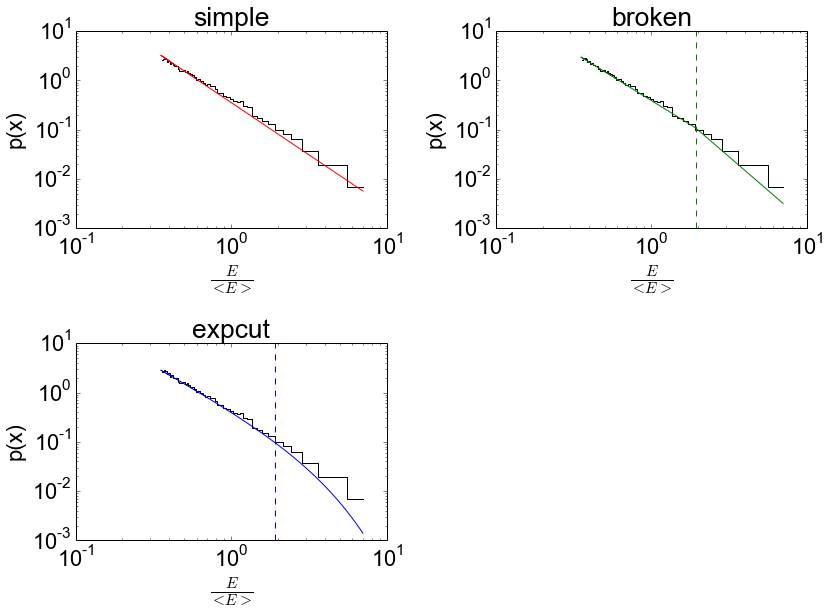

In [86]:
plot_spectrum_with_continuum_models(energies, fit_results, discrete=False)

Note that in the above plots we have indicated the break- or cutoff energy as a vertical, dashed line. We have also examined the effect of the number of bins (equally spaced bins) on the $p$-value. We do observe changes in the obtained $p$-values for the fit depending on the number of bins. In some cases the chosen number of bins results in a found break- or cutoff energy that lies outside the power law because this results in less than 20 counts in the tail, meaning we could cut the energies above break- or cutoff energy. This is probably not a good fit as it is equal to the simple power law (in the case of the broken power law), and similar (in the case of the exponentially cut-off power law). However, it is not good practice to use the number of bins as a fit value, (i.e. optimising the number of bins to obtained the highest $p$-value). But the problem is that if we adaptive binsizes we get few datapoints in the tail such that the fit of the tail makes little sense (too few dataponts, large binsizes such that it matters a lot which energy value is chosen to represent the bin), but sufficiently high resolution in the low-energy part of the spectrum such that we expect to be able to resolve emission lines, should there be any.

To try and tackle the big-bin-tail-problem we have changed the formulae which were initially the analytical formulae used with the average value of the bin, to integrated analytical formulae given in the assignment. This way the energy valye is actually integrated over the bin and we expect the bin to be better represented in the fitting routine. As a result, the function implementations do not really look elegant anymore, but the result should be better than fitting using the averaged bin value.

From the graph where we do not use the binned data to plot the model but we use a more continuously array instead it can be clearly seen that there are deviations of the model from the data, and that changing the energy value to represent the bin matters.

The next step would be to obtain confidence intervals on the obtained MLE's. In this case, however, we notice that the $p$-values are so low that calculating confidence intervals would make little to no sense whatoever. Nontheless, we were... inspired... again by Riley's method to use the `scipy.optimize.curve_fit` routine to calculate confidence intervals and to plot the residuals. In the words of Riley:
> (...) although this routine does not return the actual value of the statistic, it does return the Hessian, and we can simply obtain the statistic ourselves afterwards. This is shown below. It is worth noting that the p-value would change quite a bit if we were to change the number of bins.

In [87]:
def simple_power_law_wrapper(edges, parm0, parm1, parm2):
    """ Same same, but scipy.optimize.minimize expects different form of
        function than scipy.optimize.curve_fit does. So use this wrapper :-)... """
    N_0 = parm0
    E_0 = parm1
    Gamma = parm2

    return simple_power_law((parm0, parm1, parm2), edges)

def broken_power_law_wrapper(edges, parm0, parm1, parm2, parm3, parm4):
    N_0 = parm0
    E_0 = parm1
    Gamma_1 = parm2
    Gamma_2 = parm3
    E_bk = parm4
    
    return broken_power_law((parm0, parm1, parm2, parm3, parm4), edges)


def exponentially_cut_off_power_law_wrapper(edges, parm0, parm1, parm2, parm3):
    N_0 = parm0
    E_0 = parm1
    Gamma = parm2
    E_cut = parm3

    return exponentially_cut_off_power_law((parm0, parm1, parm2, parm3), edges)


def print_confidence_intervals_and_plot_residuals(model, result,
        adaptive=True, find_emissionline=False, print_cis=True,
        plot_residuals=True, discrete=True):
    dens, edges, err = bin_data_adaptive(energies, adaptive=adaptive)

    # Conifdence intervals
    functionpicker = {"simple": simple_power_law_wrapper ,
                      "broken": broken_power_law_wrapper,
                      "expcut": exponentially_cut_off_power_law_wrapper}
    function = functionpicker.get(model, None)
    
    if find_emissionline:
        function = gauss_wrapper
    
    if not function:
        print "Error: incorrect model name used"
        return
    
    ml_vals = result["x"]
    moddof = len(ml_vals)
    
    if print_cis:
        ml_func = result["fun"]
        dof = len(dens) - moddof
        
        print "Results for the '{0}' model:".format(model)
        print "  Using scipy.optimize.minimze to minimize chi^2 yields:"
        print "    [MLEs], chisq/dof:", ml_vals, ml_func/dof
        print
    
    ml_vals, ml_covar = scipy.optimize.curve_fit(function, edges, dens, p0=ml_vals, sigma=err,)
    ml_funcval = stat(ml_vals, edges, dens, err, model)
    
    if not result["success"]:
        print "  scipy.optimize.curve_fit broke down!\n    Reason: '{0}'".format(result["message"])
        print "  No confidence intervals have been calculated."
        return

    dof = len(dens) - moddof
    errs = numpy.sqrt(numpy.diag(ml_covar))
    if print_cis:
        print "  Using scipy.optimize.curve_fit to obtain confidence intervals yields:"
        print "    N_0 = {0:.3f} +/- {1:.3f}".format(ml_vals[0], err[0])
        print "    E_0 = {0:.3f} +/- {1:.3f}".format(ml_vals[1], err[1])
        print "    {parm2_name} = {0:.3f} +/- {1:.3f}".format(ml_vals[2], err[2],
            parm2_name="Gamma" if model in ["simple", "simple_gauss", "expcut", "expcut_gauss"] else "Gamma_1")
        if moddof > 3 and not find_emissionline:
            print "    {parm3_name} = {0:.3f} +/- {1:.3f}".format(ml_vals[3], err[3],
                parm3_name="Gamma_2" if model in ["broken", "broken_gauss"] else "E_cut")
        if moddof > 4 and not find_emissionline:
            print "    E_bk = {0:.3f} +/- {1:.3f}".format(ml_vals[4], err[4])
        if find_emissionline:
            if moddof == 7:  # broken
                print "    Gamma_2 = {0:.3f} +/- {1:.3f}".format(ml_vals[3], err[3])
                print "    E_bk = {0:.3f} +/- {1:.3f}".format(ml_vals[4], err[4])
                print "    N_line = {0:.3f} +/- {1:.3f}".format(ml_vals[5], err[5])
                print "    E_cent = {0:.3f} +/- {1:.3f}".format(ml_vals[6], err[6])
            if moddof == 6:  # expcut
                print "    E_bk = {0:.3f} +/- {1:.3f}".format(ml_vals[3], err[3])
                print "    N_line = {0:.3f} +/- {1:.3f}".format(ml_vals[4], err[4])
                print "    E_cent = {0:.3f} +/- {1:.3f}".format(ml_vals[5], err[5])
            if moddof == 5:  # simple
                print "    N_line = {0:.3f} +/- {1:.3f}".format(ml_vals[3], err[3])
                print "    E_cent = {0:.3f} +/- {1:.3f}".format(ml_vals[4], err[4])
        
        ch = scipy.stats.chi2(dof)
        pval = 1.0 - ch.cdf(ml_funcval)
        print "    p-value for this fit = {0:.5f}".format(pval)
        
    # Residuals plot
    functionpicker = {"simple": simple_power_law,
                      "broken": broken_power_law,
                      "expcut": exponentially_cut_off_power_law}
    function = functionpicker.get(model, None)

    if find_emissionline:
        function = True
    
    if not function:
        print "Error: incorrect model name used"
        return
    
    if plot_residuals:
        binsize = numpy.array([edges[i+1] - edges[i] for i in range(len(dens))])
        
        colourpicker = {"simple": "red", "broken": "green", "expcut": "blue",
                        "simple_gauss": "red", "broken_gauss": "green", "expcut_gauss": "blue"}
        col = colourpicker.get(model, "black")
        
        fig = pyplot.subplots(2, 1, figsize=(12, 9))
        gs1 = matplotlib.gridspec.GridSpec(3, 3)
        gs1.update(hspace=0)
        ax1 = pyplot.subplot(gs1[:-1,:])
        ax2 = pyplot.subplot(gs1[-1,:])
        # ax1.tick_params(labelsize=15)
        # ax2.tick_params(labelsize=15)
        # ax1.tick_params(labelbottom='off')

        ax1.set_xlim(0.2, 5.1)
        ax2.set_xlim(0.2, 5.1)

        ax1.set_ylabel("p(x)")
        ax2.set_ylabel("residuals")
        ax2.set_xlabel(r'$\frac{E}{<E>}$')
        ax1.errorbar(edges[1:] + binsize/2., dens, xerr=binsize/2., yerr=err,
                     label="data", c="black", marker='o', linestyle='', markersize=3)
        
        ax2.axhline(y=0, linewidth=2, linestyle='dashed', c="black")

        if not find_emissionline:
            ax2.errorbar(edges[1:] + binsize/2., dens - function(ml_vals, edges), yerr=err,
                         c="black", drawstyle="steps-mid")
        else:
            ax2.errorbar(edges[1:] + binsize/2., dens - gauss_plot(ml_vals, edges, model), yerr=err,
                         c="black", drawstyle="steps-mid")
        
        # Choose to display model in same bins as data (discrete) or continuously 
        if not discrete:
            edges = numpy.arange(numpy.min(energies)/numpy.mean(energies),
                                 numpy.max(energies)/numpy.mean(energies), 0.001)
            binsize = 0.001
        if not find_emissionline:
            ax1.plot(edges[1:] + binsize/2., function(ml_vals, edges),
                    label=model, c=col, drawstyle='steps-mid')
        else:
            ax1.plot(edges[1:] + binsize/2., gauss_plot(ml_vals, edges, model),
                    label=model, c=col, drawstyle='steps-mid')            
        
        if model == "broken":
            break_or_cut = ml_vals[4]
            ax1.axvline(break_or_cut, ls="dashed", c=col)
        elif model == "expcut":
            break_or_cut = ml_vals[3]
            ax1.axvline(break_or_cut, ls="dashed", c=col)

        ax1.legend()
        
        # fix overlapping ticks
        ax2.set_ylim(ymax=0.099)
        ax1.tick_params(labelbottom='off')
        nbins = len(ax2.get_yticklabels())
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))
        
        # log-log
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        ax1.set_yscale('log')
        
        pyplot.show()

Results for the 'simple' model:
  Using scipy.optimize.minimze to minimize chi^2 yields:
    [MLEs], chisq/dof: [ 0.60459039  0.77762937  2.12076435] 7.25916340447

  Using scipy.optimize.curve_fit to obtain confidence intervals yields:
    N_0 = 0.605 +/- 0.132
    E_0 = 0.778 +/- 0.134
    Gamma = 2.121 +/- 0.141
    p-value for this fit = 0.00000


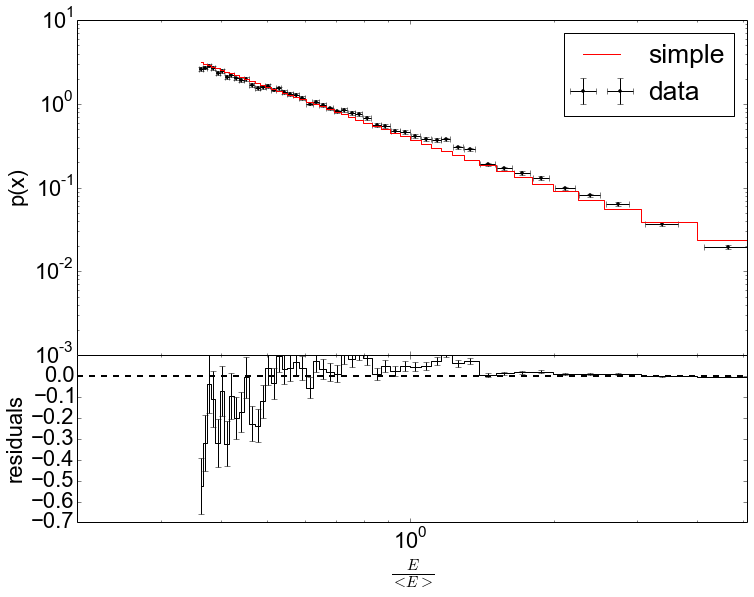


Results for the 'broken' model:
  Using scipy.optimize.minimze to minimize chi^2 yields:
    [MLEs], chisq/dof: [ 0.83174927  0.67837549  1.94912885  2.72820151  1.92582045] 2.22975341851

  Using scipy.optimize.curve_fit to obtain confidence intervals yields:
    N_0 = 0.832 +/- 0.132
    E_0 = 0.678 +/- 0.134
    Gamma_1 = 1.949 +/- 0.141
    Gamma_2 = 2.728 +/- 0.133
    E_bk = 1.926 +/- 0.116
    p-value for this fit = 0.00000


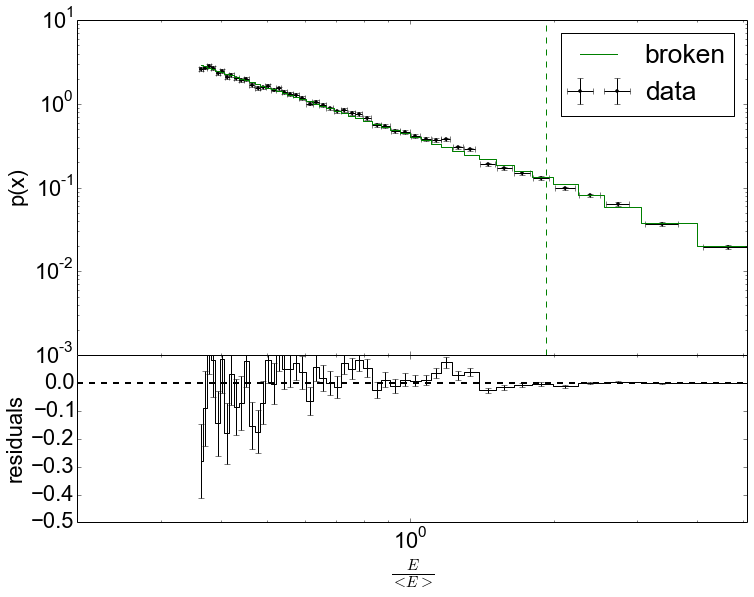


Results for the 'expcut' model:
  Using scipy.optimize.minimze to minimize chi^2 yields:
    [MLEs], chisq/dof: [ 0.10875274  1.58259172  0.73248181  1.92148886] 1.87935138488

  Using scipy.optimize.curve_fit to obtain confidence intervals yields:
    N_0 = 0.109 +/- 0.132
    E_0 = 1.583 +/- 0.134
    Gamma = 0.732 +/- 0.141
    E_cut = 1.921 +/- 0.133
    p-value for this fit = 0.00028


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:61: RuntimeWarning: floating point number truncated to an integer


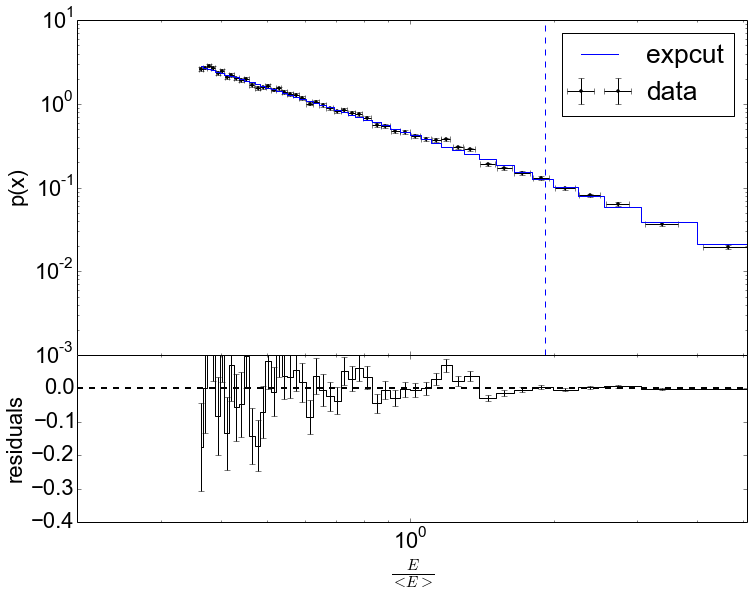

In [88]:
if __name__ == '__main__':
    for model, result in fit_results.iteritems():
        print_confidence_intervals_and_plot_residuals(model, result)
        print 

In the words of Riley:
> The plot above shows the results of the optimization.

Firstly, we observe that the $p$-values of the fits are rather low, which indicates that the fits should probably be rejected. However, we are trying to fit an emission line next hopefully improving the obtained $p$-value. In order to find our initial expected value for the emission line energy and its intensity we have to inspect the residuals. We do not really see hints for emission lines in the residuals, but maybe there is a little something around 1.2 $E/<E>$, so we will try to fit this.

### Question 3
- Search for emission lines, which may carry crucial information if they are associated with specific dark matter particle decays. You may assume a Gaussian profile to fit the emission line:
$$ dN = \frac{N_{\rm line}}{\sigma \sqrt{2 \pi}} \exp\left( \frac{(E - E_{\rm cent})^2)}{2 \sigma^2} \right) dE $$ where $E_{\rm cent}$ is the line centroid energy, $\sigma$ is the line width and $N_{\rm line}$ is the expected total number of photons contained in the line. The width of any lines is set by the instrumental resolution (which is a function of energy) and is given by:

$$ \sigma = 2.0 \sqrt{\frac{E_{\rm cent}}{200 \, \rm{ GeV}}} \, \rm{ Gev} $$

### Answer 3


So the first thing we will do is define the Gauss function, which is integrated since we integrate over the bins. A bit of caution is required here since sigma is given in units of GeV, but we have chosen at the start to divide the mean of the energies out. So we need to correct sigma for this such that it is unitless. Mind you, E_cent is also given in $E/<E>$! So therefore we are left with multiplying the denominator in the sqrt with the mean. Next, we integrate over the bins such that the indices of the gauss function match with the indices of the power-law functions so we can simply take the sum of both functions. For this purpose we have to define a wrapper around the gaus function to ensure all fit-parameters are passed to the correct function. This is not trivial, but since all three model power-laws have different numbers of fit parameters this is very well manageable. Note that the parameters to pass to the Gauss function are appended to the list of guess (initial) parameters, so they are always the last two in the tuple. 

Mind you, the code for stat (the ($chi^2$ model) has also been updated because the scipy.optimize.minimize and the scipy.optimize.curve_fit functions eat the fit parameters in a different representation (tuple vs explicitly passing them). Finally, to generate the residuals the function definitions including the emission line has to be used. For this purpose there is a gauss_plot wrapper function to return the continuum model plus emission line function values.

For the sake of checking the Gauss function a small plot is provided to ensure that the emission line looks sensible and behaves as expected (which it does).

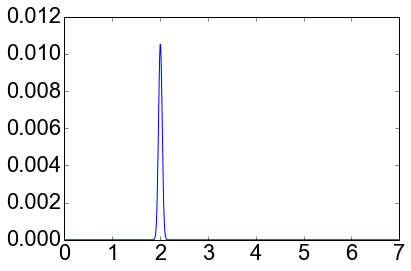

In [89]:
def gauss(parm, edges):
    E_cent = parm[-1]
    N_line = parm[-2]
    mean = numpy.mean(parse_and_clean_dataset()) 
    sigma = 2.0 * numpy.sqrt(E_cent / (200.*mean))  # Because E_cent given is E_cent/<E>
    # print sigma
    
    # We have given the edges which allow us to do the integration over the bin
    E_left = edges[:-1]
    E_right = edges[1:]
    binsize = E_right - E_left
    
    # Formula integrated over bin
    cst = N_line/(sigma*numpy.sqrt(2*numpy.pi)) * numpy.sqrt(numpy.pi/2) * -1.0*sigma
    counts = cst*scipy.special.erf((E_cent-E_right)/(numpy.sqrt(2)*sigma)) - \
        cst*scipy.special.erf((E_cent-E_left)/(numpy.sqrt(2)*sigma))
    
    # Now transform to density instead of counts
    dens = counts / binsize
    
    return dens

def gauss_wrapper(edges, parm0, parm1, parm2, parm3, parm4, parm5=None, parm6=None):
    ''' The different models have different nr of fit parm, but always the last two parameters 
        are the Gauss parameters.  '''
    # simple has three fit parameters
    parm_pl = (parm0, parm1, parm2)
    parm_gauss = (parm3, parm4)
    function = simple_power_law
    if parm5:
        # expcut has four fit parameters
        # not simple but expcut if parm6 is not also given
        parm_pl = (parm0, parm1, parm2, parm3)
        parm_gauss = (parm4, parm5)
        function = exponentially_cut_off_power_law
    if parm6:
        # broken has five fit parameters
        # not expcut but broken
        parm_pl = (parm0, parm1, parm2, parm3, parm4)
        parm_gauss = (parm5, parm6)
        function = broken_power_law
        
    return function(parm_pl, edges) + gauss(parm_gauss, edges)

def gauss_plot(parm, edges, dist):
    if "gauss" in dist:
        dist = dist.split("_")[0]
        E_cent = parm[-1]
        N_line = parm[-2]
    if dist == "simple":
        ymod = simple_power_law(parm, edges)
    elif dist == "broken":
        ymod = broken_power_law(parm, edges)
    elif dist == "expcut":
        ymod = exponentially_cut_off_power_law(parm, edges)
    else:
        print "This function is not defined....choose another"
        return None 
    if "gauss" in dist:
        ymod += gauss(parm, edges)
    return ymod


if __name__ == '__main__':
    x = numpy.arange(0, 200/28, 0.01)
    pyplot.plot(x[1:], gauss((0.001, 2), x))

As a sanity check we first look at the behaviour of the Gauss fuction. parm=(N_line, E_cent), so if we specify a given E_cent, we should see a peak centered around that value. We can use N_line to set the intensity of the emission line. Note that sigma is not self-given as it is set by the instrumental resolution. It is a function of E_cent, and indeed we see that it changes for different E_cent given. Now we can simply fit using the sum of the gauss function and the powerlaw model.

[MLEs], chisq/dof: [ 0.60459038  0.77762938  2.12076436  0.01        1.2       ] 7.58179288911
The p-value for the simple_gauss distribution is: 0.00000
[MLEs], chisq/dof: [ 0.83174927  0.67837549  1.94912885  2.72820151  1.92582045  0.01        1.2       ] 2.33346287983
The p-value for the broken_gauss distribution is: 0.00000
[MLEs], chisq/dof: [ 0.10875274  1.58259172  0.73248181  1.92148886  0.01        1.2       ] 1.96477644783
The p-value for the expcut_gauss distribution is: 0.00014


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:61: RuntimeWarning: floating point number truncated to an integer


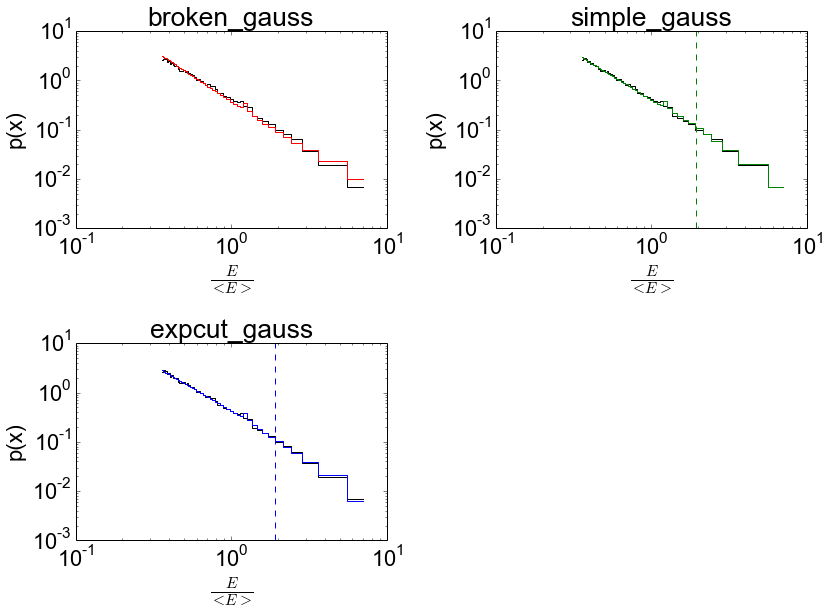

In [90]:
if __name__ == '__main__':
    fit_results = fit_observed_spectrum_with_continuum_models(energies, adaptive=True, find_emissionline=True)

Notice that the expcut_gauss has weird MLE's and therefore the plot does not show the model. The fitting routine clearly broke down.

Again, show without the binned model data (in this case it shows the emission line much more clearly).

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:61: RuntimeWarning: floating point number truncated to an integer


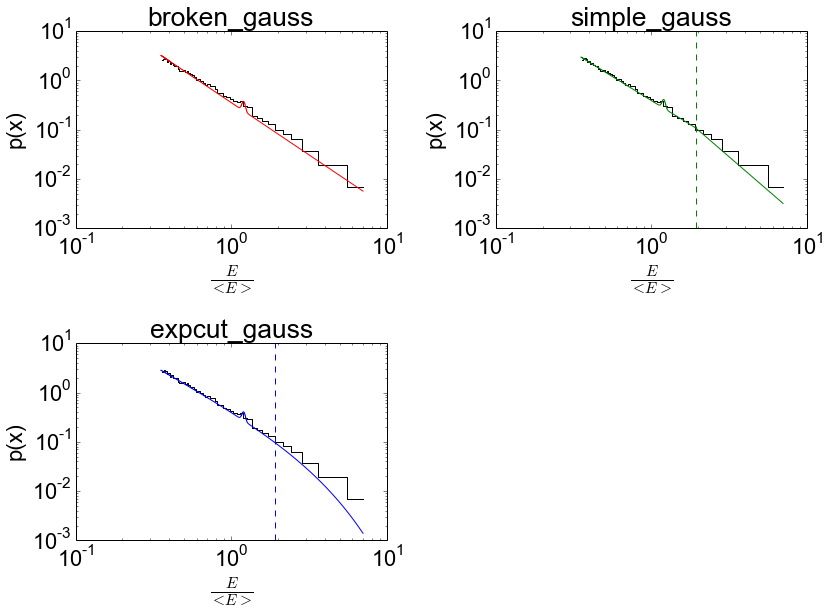

In [91]:
if __name__ == '__main__':
    plot_spectrum_with_continuum_models(energies, fit_results, adaptive=True, discrete=False)

Next we obtain the confidence intervals on the fit with the emission line (but note that the emission line has a rather low N_line found by the fitting routine, which indicates that there is no emission line present).

In [95]:
if __name__ == '__main__':
    for model, result in fit_results.iteritems():
        print_confidence_intervals_and_plot_residuals(model, result, find_emissionline=True, plot_residuals=False)

Results for the 'broken_gauss' model:
  Using scipy.optimize.minimze to minimize chi^2 yields:
    [MLEs], chisq/dof: [ 0.83174927  0.67837549  1.94912885  2.72820151  1.92582045  0.01        1.2       ] 2.33346287983

  Using scipy.optimize.curve_fit to obtain confidence intervals yields:
    N_0 = 0.636 +/- 0.132
    E_0 = 0.776 +/- 0.134
    Gamma_1 = 1.962 +/- 0.141
    Gamma_2 = 2.728 +/- 0.133
    E_bk = 1.973 +/- 0.116
    N_line = 0.005 +/- 0.119
    E_cent = 1.231 +/- 0.108
    p-value for this fit = 0.00000
Results for the 'simple_gauss' model:
  Using scipy.optimize.minimze to minimize chi^2 yields:
    [MLEs], chisq/dof: [ 0.60459038  0.77762938  2.12076436  0.01        1.2       ] 7.58179288911

  Using scipy.optimize.curve_fit to obtain confidence intervals yields:
    N_0 = 0.675 +/- 0.132
    E_0 = 0.736 +/- 0.134
    Gamma = 2.127 +/- 0.141
    N_line = 0.009 +/- 0.133
    E_cent = 1.230 +/- 0.116
    p-value for this fit = 0.00000
Results for the 'expcut_gauss' model:

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:61: RuntimeWarning: floating point number truncated to an integer


Our final conclusion is that the fits were poor without the emission line, but slightly better with the exponentially cut Gaussian model including an emission line. However, the intensity of the emission line is so low that it could very well be disregarded altogether.

The only possibility I see left is that if there is an emission line it is either in the tail of the distribution (which is nearly impossible to find), or perhaps in the low-energy part of the spectrum.

### Question 4
- [Professor Denzil Dexter](http://www.teachertube.com/video/professor-denzil-dexter-81357) of the University of Southern California has proposed a dark matter candidate particle, the _Dextron_, which should result in a Gaussian emission line of width 1 GeV at an energy of 45.3 GeV. In case this line isn't detected, use your data to set a $3\sigma$ upper limit on the predicted number of photons that this line could contain.

Note that in all cases you should estimate $p$-values and significances for your hypothesis tests. You should explain your reasoning and choices and discuss how you interpret your results as you go along. Make sure that you make sensible decisions about how your report your results, e.g. about the number of significant figures used. You should also, in as much as possible, determine confidence intervals on the best-fitting model parameters (for continuum and emission line models). If errors appear to be correlated between parameters, you should also attempt to plot 2-dimensional confidence contours.Overall, we are looking for evidence that you understand and can apply the material in the course on model-fitting, parameter estimation and hypothesis testing, so you will find the information in the lectures in weeks 4, 5 and 6 to be very useful, as well as the case studies lecture from week 6.

### Answer 4

To answer this question the fitting routine has to be performed again but setting the E_cent parameter fixed to 45.3 GeV (not leaving it as a free fit parameter). 

In order to obtain the 3$\sigma$ upper limit we steal Riley's code again (this time from the previous assignment question 6). This code can be adjusted such that it can be used. We now have to find 

Note that the number of photons can be obtained by taking the density value and multiplying it by the bin width.

In [104]:
p = 0.00713
# Calculate the corresponding sigma for this p-value - this of course assumes the incorrect distribution (normal),
# but it is nonetheless a useful quantitiy for us to quote
def p_to_sigmas(pval):
    nd = scipy.stats.norm(0., 1.)
    return nd.ppf(1.0-pval/2.)

# We can then output the p-value with the corresponding significance, remembering to quote sensible precision
print "The p-value is %.3f and this corresponds to a %.3f sigma significance"%(p,p_to_sigmas(p))

# First let's create a function to convert the sigma siginificance into a p-value
def sigmas_to_p(sigval):
    nd = scipy.stats.norm(0., 1.)
    return 2.*(1.-nd.cdf(sigval))

p = sigmas_to_p(3)
print p

# Create a function that we want to minimize - the difference between the known p value and 
# the p-value returned by the poisson distibrution with the total count rate (source+background)
def f(lam):
    return abs(p - scipy.stats.poisson.cdf(7,lam))

# Optimize the function above such that we find the lambda that returns a value as close to the given 
# p-value as possible.....start from lambda = 10 and let the optimiser find the true value
result = scipy.optimize.minimize(f,10,method='BFGS')
print "The 3-sigma upper limit is:  ",result['x'][0]

The p-value is 0.007 and this corresponds to a 2.691 sigma significance
0.00269979606326
The 3-sigma upper limit is:   18.1081880642
